In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import datetime
import requests
import json

import xdmod.datawarehouse as xdw
import xdmod.visualizer as v
import xdmod.visualizer_test as vt

from IPython.display import display, Markdown, JSON

In [27]:
# config variables

# dictionary mapping hostname -> url
hosts = {'metrics-dev': 'https://metrics-dev.ccr.buffalo.edu:9004', 
         'ookami': 'https://ookami.ccr.xdmod.org',
         'xdmod-dev': 'https://xdmod-dev.ccr.xdmod.org:9002'}

# today -> monday when notebook is executed
today = date.today()
sunday = today - datetime.timedelta(days=1)
last_monday = today - datetime.timedelta(days=7)
last_sunday = last_monday - datetime.timedelta(days=1)
lastlast_monday = last_monday - datetime.timedelta(days=7)

display(Markdown(f'# Full Report {today.strftime("%Y-%m-%d")}'))

# Full Report 2022-08-01

## metrics-dev

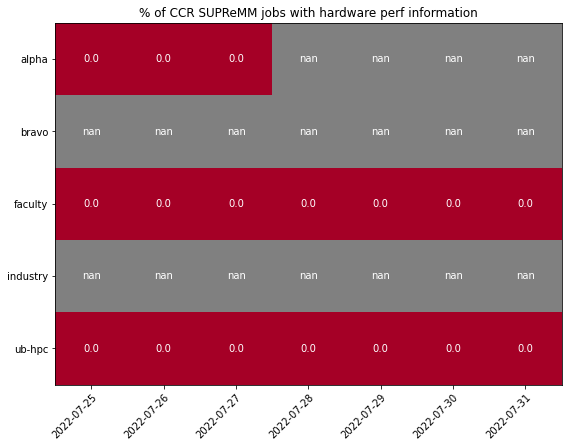

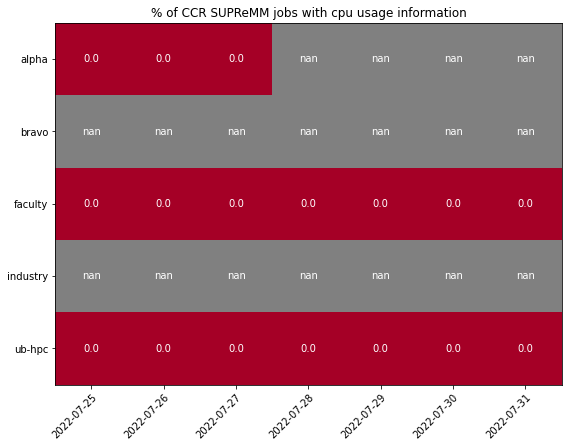

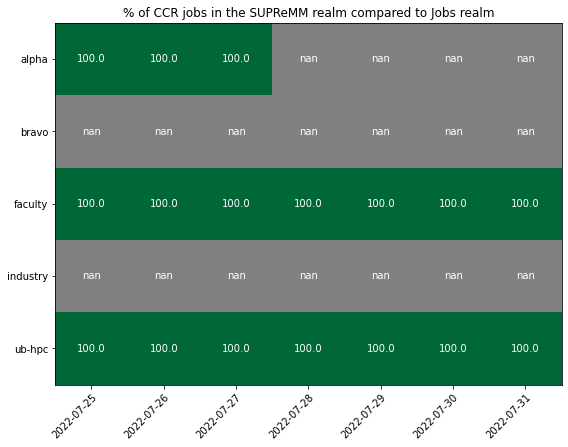

## ookami

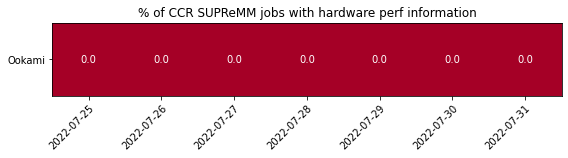

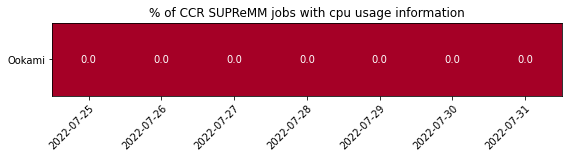

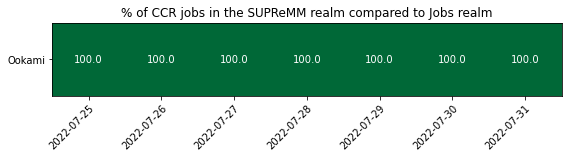

## xdmod-dev

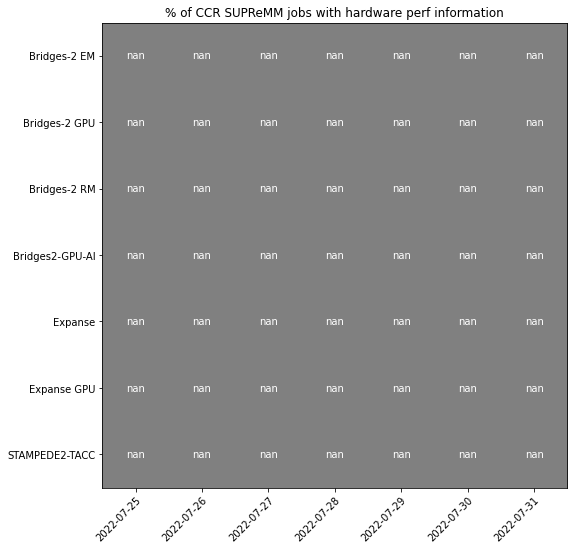

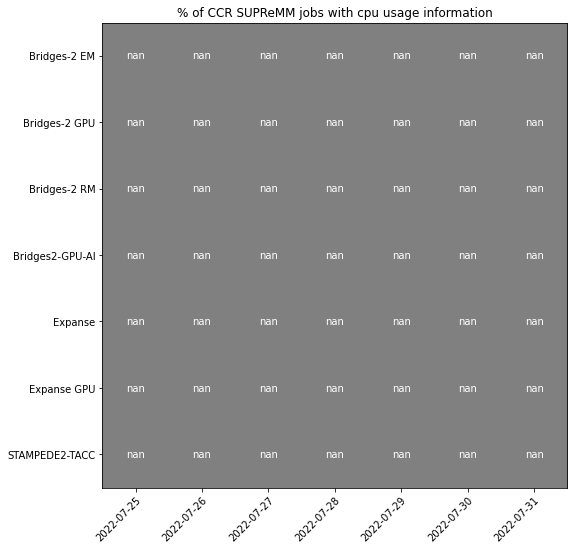

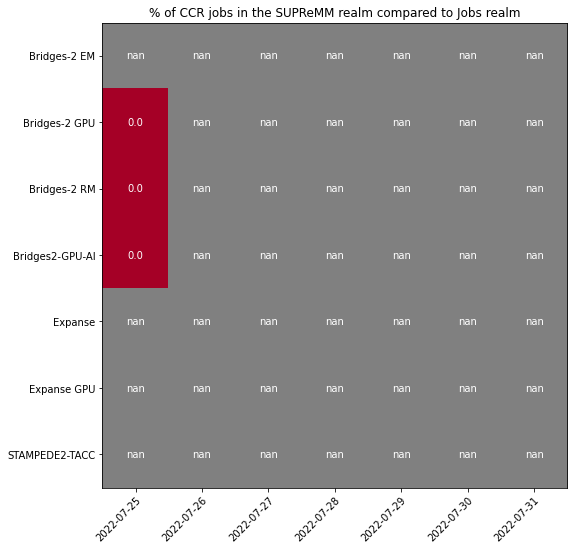

In [28]:
for host in hosts:
    display(Markdown(f'## {host}'))
    for type in ['hardware', 'cpu','realms']:
        config = {"start": last_monday, "end": sunday, "type": type}
        config_lastweek = {"start": lastlast_monday, "end": last_sunday, "type": type}  
        with xdw.DataWareHouse(hosts[host]) as test:
                data = test.get_qualitydata(config)
                #lastweek_data = test.get_qualitydata(config_lastweek)
                vt.quality_heatmap(data)

In [24]:
# alerts setup

# path to report in html format
html_path = f'reports/xdmod-alerts/{today.strftime("%Y-%m-%d")}_report.html'

# Slack webhook for post request
# DO NOT EXPOSE ON GITHUB
webhook = ''

In [23]:
type_to_title = {'gpu': '% of CCR SUPReMM jobs with GPU information', 
                'hardware': '% of CCR SUPReMM jobs with hardware perf information', 
                'cpu': '% of CCR SUPReMM jobs with cpu usage information', 
                'script': '% of CCR SUPReMM jobs with Job Batch Script information', 
                'realms': '% of CCR jobs in the SUPReMM realm compared to Jobs realm'}

payload = {"blocks": [{"type": "section","text": {"type": "mrkdwn","text": f'*SUPReMM Quality Alerts {today}*'}}]}

for host in hosts:
    payload['blocks'].append({"type": "divider"})
    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'*{host}*'}})
    with xdw.DataWareHouse(hosts[host]) as warehouse:
        for type in ['hardware', 'cpu', 'realms']:
            today_data = warehouse.get_qualitydata({"start": last_monday, "end": sunday, "type": type})
            lastweek_data = warehouse.get_qualitydata({"start": lastlast_monday, "end": last_sunday, "type": type})
            for res in today_data.index:
                if lastweek_data.mean(axis='columns')[res] + today_data.mean(axis='columns')[res] >= 10: # change to minus
                    alert = today_data.loc[res]
                    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'Attention needed at: *{type_to_title[type]}* from the *{alert.name}* resource'}})
                    
payload['blocks'].append({"type": "divider"})
payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'{hosts["metrics-dev"]}/{html_path}'}})                
                
response = requests.post(webhook, data = json.dumps(payload))
print(response.text)

ok
